In [1]:
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sktime")
from src.recording_generator import RecordingGenerator

## functions

In [2]:
def get_noised_recording(rec, num_stim = 15, num_samples = 300, window_size = 200, window_offset = 50, white_SNR_dB=20, mains_SNR_dB=20, spontaneous_firing_Hz=1000):
    """
    rec: RecordingGenerator 
    """
    SAs, SA_indexes, APs, AP_indexes, is_spike, amount_spike, data = rec.generate(num_stim, verbose=0)
    noised_data = rec.add_white_noise(data, SNR_dB=white_SNR_dB)
    noised_data = rec.add_mains_electricity_noise(noised_data, SNR_dB=mains_SNR_dB)
    noised_data = rec.add_spontaneous_spikes(noised_data, firing_Hz=spontaneous_firing_Hz)

    SA_ends = [idx[-1] for idx in SA_indexes]
    SA_size = len(SA_indexes[0])

    X, y_class, y_reg = np.zeros((num_samples, window_size)), np.zeros(num_samples), np.zeros(num_samples)
    i = 0
    while i < num_samples:
        for SA_end_idx in range(len(SA_ends)-1):
            if i >= num_samples: break
            window_start = SA_ends[SA_end_idx]

            # while the window fits in this segment (so before the next stimulus)
            while window_start < SA_ends[SA_end_idx+1]-SA_size-window_size:
                if i >= num_samples: break
                X[i] = noised_data[window_start:window_start+window_size]
                # if more than 90% of the samples in this window are spikes then it is a spiking window
                y_class[i] = is_spike[window_start: window_start+window_size].mean() > 0.90 
                # count spikes fully contained in this window
                y_reg[i] = len([x for x in AP_indexes if x[0] >= window_start and x[-1] <= window_start+window_size])
                window_start += window_offset
                i += 1

    return X, y_class, y_reg


def make_dataset(
    n = 2000,
    first_AP_stim_lambda_ms = 0.2,
    AP_length_mean_std_ms = [5, 1],
    AP_amplitude_mean_std_pct = [10, 0.5],
    SA_amplitude_mean_std_pct = [1, 0.1],
    num_cells = 50,
    spike_train_start_lambda_ms = 1,
    spike_train_rate_lambda = 3,
    inter_spike_train_interval_lambda_ms = 5,
    CAP_jitter_mean_std_ms = [1, 0.1],
    template_jitter_ms = 1, 
    num_stim = 15,
    num_samples = 2000, 
    window_size = 200, 
    window_offset = 50, 
    white_SNR_dB=20, 
    mains_SNR_dB=20, 
    spontaneous_firing_Hz=1000):

    n_cells_spike = n//2
    n_cells_no_spike = n_no_cells_no_spike = n//4

    rec_cells = RecordingGenerator(first_AP_stim_lambda_ms=first_AP_stim_lambda_ms,
                                      AP_length_mean_std_ms=AP_length_mean_std_ms,
                                      AP_amplitude_mean_std_pct=AP_amplitude_mean_std_pct,
                                      SA_amplitude_mean_std_pct=SA_amplitude_mean_std_pct,
                                      num_cells=num_cells,
                                      spike_train_start_lambda_ms=spike_train_start_lambda_ms,
                                      spike_train_rate_lambda=spike_train_rate_lambda,
                                      inter_spike_train_interval_lambda_ms=inter_spike_train_interval_lambda_ms,
                                      CAP_jitter_mean_std_ms=CAP_jitter_mean_std_ms,
                                      template_jitter_ms=template_jitter_ms)
    
    rec_no_cells = RecordingGenerator(first_AP_stim_lambda_ms=first_AP_stim_lambda_ms,
                                      AP_length_mean_std_ms=AP_length_mean_std_ms,
                                      AP_amplitude_mean_std_pct=AP_amplitude_mean_std_pct,
                                      SA_amplitude_mean_std_pct=SA_amplitude_mean_std_pct,
                                      num_cells=0,
                                      spike_train_start_lambda_ms=spike_train_start_lambda_ms,
                                      spike_train_rate_lambda=spike_train_rate_lambda,
                                      inter_spike_train_interval_lambda_ms=inter_spike_train_interval_lambda_ms,
                                      CAP_jitter_mean_std_ms=CAP_jitter_mean_std_ms,
                                      template_jitter_ms=template_jitter_ms)

    X_cells, y_class_cells, y_reg_cells = get_noised_recording(rec_cells, num_stim=num_stim, num_samples=num_samples, window_size=window_size, window_offset=window_offset, white_SNR_dB=white_SNR_dB, mains_SNR_dB=mains_SNR_dB, spontaneous_firing_Hz=spontaneous_firing_Hz)
    X_no_cells, y_class_no_cells, y_reg_no_cells = get_noised_recording(rec_no_cells, num_stim=num_stim, num_samples=num_samples, window_size=window_size, window_offset=window_offset, white_SNR_dB=white_SNR_dB, mains_SNR_dB=mains_SNR_dB, spontaneous_firing_Hz=spontaneous_firing_Hz)

    X = np.concatenate([X_cells[y_class_cells==1][:n_cells_spike], 
                        X_cells[y_class_cells==0][:n_cells_no_spike], 
                        X_no_cells[:n_no_cells_no_spike]])
    
    y_class = np.concatenate([y_class_cells[y_class_cells==1][:n_cells_spike], 
                              y_class_cells[y_class_cells==0][:n_cells_no_spike], 
                              y_class_no_cells[:n_no_cells_no_spike]])
    
    y_reg = np.concatenate([y_reg_cells[y_class_cells==1][:n_cells_spike], 
                              y_reg_cells[y_class_cells==0][:n_cells_no_spike], 
                              y_reg_no_cells[:n_no_cells_no_spike]])

    return X, y_class, y_reg

In [3]:
def plot_labels(X,y):
    label_0_indices = np.where(y == 0)[0]
    label_1_indices = np.where(y == 1)[0]

    # Select 5 cases from each label
    n_samples_to_plot = 5
    label_0_samples = label_0_indices[:n_samples_to_plot]
    label_1_samples = label_1_indices[:n_samples_to_plot]

    # Create a plot for both labels
    plt.figure(figsize=(10, 6))

    # Plot 5 cases from label 0
    for idx in label_0_samples:
        plt.plot(X[idx, 0, :], label=f"Label 0 - Sample {idx}", color='pink', alpha=0.6)

    # Plot 5 cases from label 1
    for idx in label_1_samples:
        plt.plot(X[idx, 0, :], label=f"Label 1 - Sample {idx}", color='olive', alpha=0.4)

    # Add legend and labels
    plt.title('5 Instances of Each Label')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Show plot
plt.show()

In [4]:
def plot_incorrect_classifications(data_test, labels_test, y_pred, num_samples=10):
    """
    Plot incorrectly classified samples with true and predicted labels, colored by true label.

    Parameters:
    - data_test: The test dataset (3D array).
    - labels_test: True labels for the test dataset.
    - y_pred: Predicted labels for the test dataset.
    - num_samples: Number of incorrectly classified samples to plot.
    """
    # Identify incorrectly classified indices
    incorrect_indices = np.where(labels_test != y_pred)[0]

    # Limit to the specified number of incorrectly classified instances
    num_plots = min(num_samples, len(incorrect_indices))
    
    if num_plots == 0:
        print("No incorrectly classified samples to plot.")
        return

    # Create a color map for the labels
    unique_labels = np.unique(labels_test)
    colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors

    # Create a figure for the plot
    plt.figure(figsize=(10, 5))
    
    for i, index in enumerate(incorrect_indices[:num_plots]):
        # Get the color for the true label
        color = colors(labels_test[index])
        plt.plot(data_test[index].flatten(), label=f'True: {labels_test[index]}, Predicted: {y_pred[index]}', color=color)

    plt.title('Incorrectly Classified Samples')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
def cutoff_SA(data, eye_index, start, sa_length, offset, no_sa):

    processed_eye = []

    for channel in data[eye_index]:

        # Initialize a list to store the processed data for the current channel
        processed_channel = []

        # Set the current index to start
        current_index = start

        for _ in range(no_sa):
            # Ensure we do not exceed the length of the data
            if current_index + sa_length > len(channel):
                break

            # Cut off the segment (remove 300 and jump 2700)
            processed_segment = channel[current_index+sa_length:current_index + offset]
            processed_channel = np.hstack((processed_channel,processed_segment))

            # Jump to the next position
            current_index += offset  # 300 + 2700 = 3000 total jump


        processed_eye.append(processed_channel)

    return processed_eye 

In [6]:
def conf_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Hivecote

In [7]:
data, labels, _ = make_dataset(AP_amplitude_mean_std_pct=[1, 0.2])

In [8]:
# Shuffle the data and create train-test split
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
data_train_3d = data_train[:, np.newaxis, :]  # Shape: (8000, 1, 200)
data_test_3d = data_test[:, np.newaxis, :]    # Shape: (2000, 1, 200)

# Convert labels to pandas Series
labels_train_series = pd.Series(labels_train)
labels_test_series = pd.Series(labels_test)



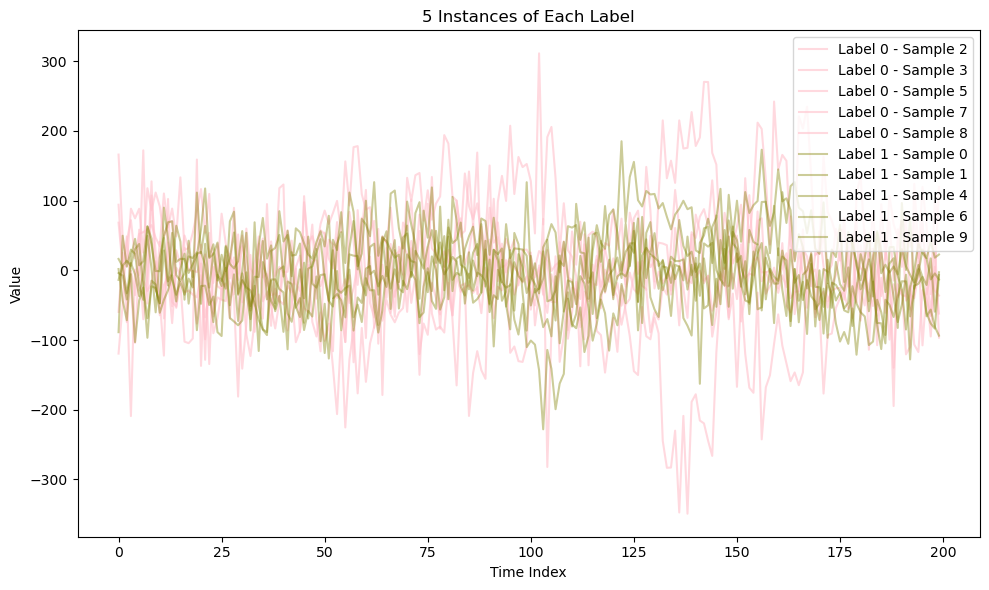

In [9]:
plot_labels(data_train_3d,labels_train)

In [10]:
classifier = HIVECOTEV2(time_limit_in_minutes=2,verbose=1)
classifier.fit(data_train_3d, labels_train_series)
y_pred = classifier.predict(data_test_3d)

# Evaluate accuracy
accuracy = accuracy_score(labels_test_series, y_pred)
print(f"Accuracy: {accuracy}")

STC  10:35:40 29/10/2024
STC train estimate  10:35:45 29/10/2024
STC weight = 0.8649356019288634
DrCIF  10:36:23 29/10/2024
DrCIF train estimate  10:36:25 29/10/2024
DrCIF weight = 0.2791508330934144
Arsenal  10:36:45 29/10/2024
Arsenal train estimate  10:36:48 29/10/2024
Arsenal weight = 0.4875797927491759
TDE  10:37:18 29/10/2024
TDE train estimate  10:37:18 29/10/2024
TDE weight = 0.6782448969140624
Accuracy: 0.995


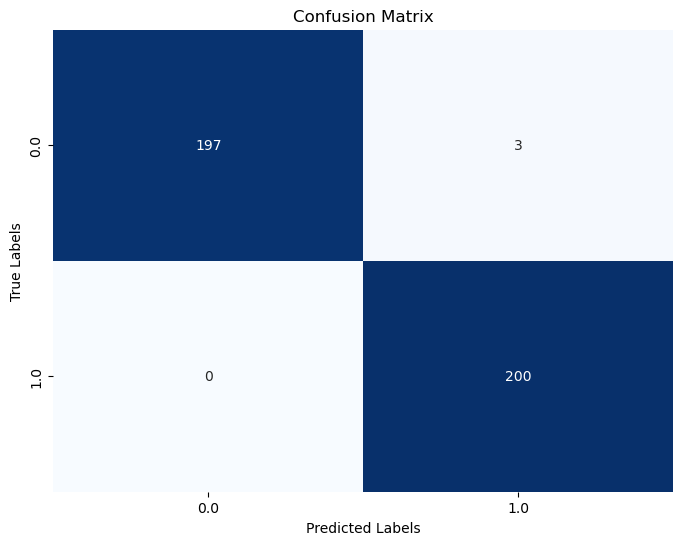

In [36]:
conf_matrix(labels_test, y_pred)

/tmp/ipykernel_14518/879086309.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set3', len(unique_labels))  # Use a colormap with distinct colors


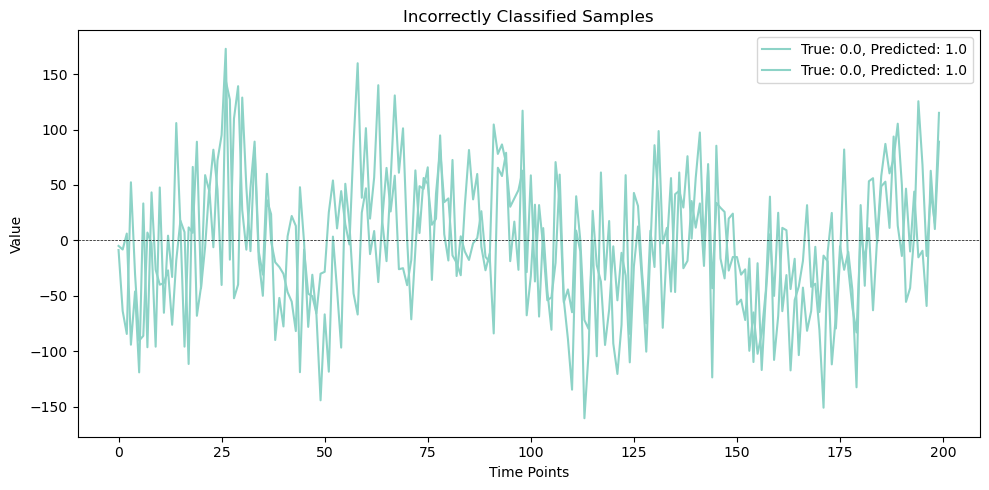

In [41]:
plot_incorrect_classifications(data_test_3d,labels_test,y_pred)

### Test of real data

In [17]:
import neo
from src.utils import get_signal_by_type

all_data_3D = []
all_data_3D_TTX = []
for eye in range(1, 7):
    time, signal = get_signal_by_type(eye=eye, design='3D', experiment='stimulated', verbose=0)
    all_data_3D.append(signal)

    time, signal = get_signal_by_type(eye=eye, design='3D', experiment='TTX', verbose=0)
    all_data_3D_TTX.append(signal)

    
all_data_3D = np.array(all_data_3D)
all_data_3D = np.transpose(all_data_3D, (0, 2, 1)) 
average_per_eye_3D = np.mean(all_data_3D, axis=1)
# Print shape of the data
print(f"Data shape: {np.shape(all_data_3D)}")
print(f"Data shape: {np.shape(average_per_eye_3D)}")

all_data_3D_TTX = np.array(all_data_3D_TTX)
all_data_3D_TTX = np.transpose(all_data_3D_TTX, (0, 2, 1)) 
average_per_eye_3D_TTX = np.mean(all_data_3D, axis=1)
# Print shape of the data
print(f"Data shape: {np.shape(all_data_3D_TTX)}")
print(f"Data shape: {np.shape(average_per_eye_3D_TTX)}")


Data shape: (6, 32, 300300)
Data shape: (6, 300300)
Data shape: (6, 32, 300300)
Data shape: (6, 300300)


In [18]:
processed_all_eyes_3D = [
    cutoff_SA(all_data_3D, eye_index=0, start=905, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=1, start=430, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=2, start=1850, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=3, start=480, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=4, start=2635, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D, eye_index=5, start=1455, sa_length=300, offset=3000, no_sa=100)
]

processed_all_eyes_3D_TTX = [
    cutoff_SA(all_data_3D_TTX, eye_index=0, start=1890, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=1, start=1765, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=2, start=2800, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=3, start=440, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=4, start=280, sa_length=300, offset=3000, no_sa=100),
    cutoff_SA(all_data_3D_TTX, eye_index=5, start=1380, sa_length=300, offset=3000, no_sa=100)
]


In [21]:
real_test_data = []
data = np.array(processed_all_eyes_3D_TTX[2][0])
random_numbers = np.random.randint(0, len(processed_all_eyes_3D_TTX[2][0]), 100)
for idx in random_numbers:
    if idx + 200 <= len(data ):
        real_test_data.append(data [idx: idx + 200])
    
    if len(real_test_data) >= 2000:
        break

print(f"Collected {len(real_test_data)} real_test_data")

real_test_data_array = np.array(real_test_data)
real_test_data_array = real_test_data_array[:, np.newaxis, :] 

Collected 100 real_test_data


In [22]:
y_pred = classifier.predict(real_test_data_array)

In [23]:
sum(y_pred)

89.0

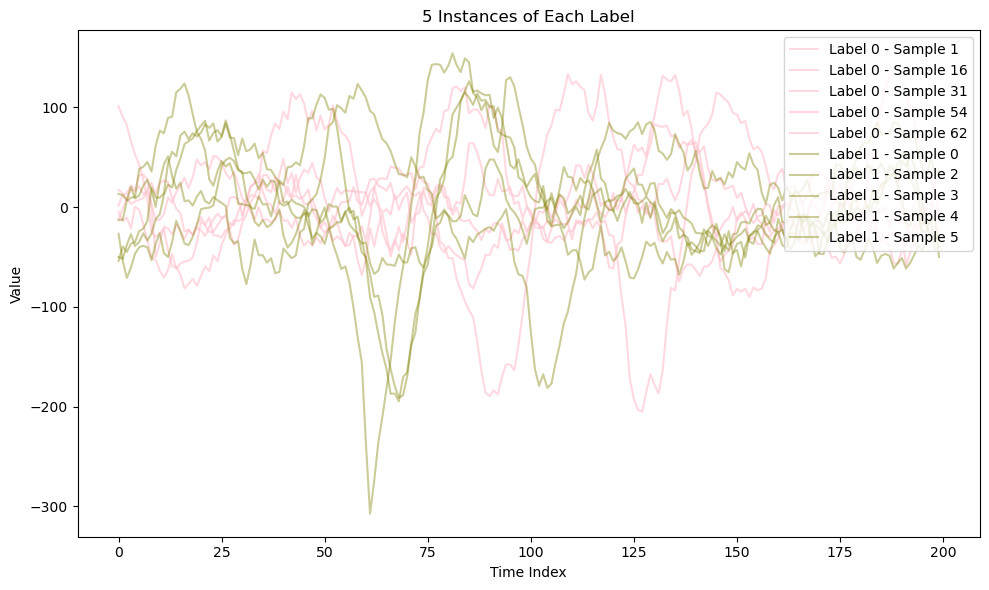

In [24]:
plot_labels(real_test_data_array,y_pred)